Check the runtime  

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Mon Oct  2 04:46:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                            

GPT-4

Epoch 1/3
246/246 [==============================] - 29s 113ms/step - loss: 0.5106 - accuracy: 0.7630 - val_loss: 0.4336 - val_accuracy: 0.8058
Epoch 2/3
246/246 [==============================] - 16s 65ms/step - loss: 0.1588 - accuracy: 0.9426 - val_loss: 0.5060 - val_accuracy: 0.7971
Epoch 3/3
154/154 [==============================] - 0s 1ms/step
Epoch 1/3
246/246 [==============================] - 30s 116ms/step - loss: 0.4945 - accuracy: 0.7725 - val_loss: 0.4116 - val_accuracy: 0.8155
Epoch 2/3
246/246 [==============================] - 17s 70ms/step - loss: 0.1915 - accuracy: 0.9302 - val_loss: 0.4645 - val_accuracy: 0.8107
Epoch 3/3
154/154 [==============================] - 0s 2ms/step
Epoch 1/3
246/246 [==============================] - 34s 128ms/step - loss: 0.4842 - accuracy: 0.7845 - val_loss: 0.4207 - val_accuracy: 0.8208
Epoch 2/3
246/246 [==============================] - 16s 62ms/step - loss: 0.1705 - accuracy: 0.9341 - val_loss: 0.5591 - val_accuracy: 0.7941
Epoch 3/3

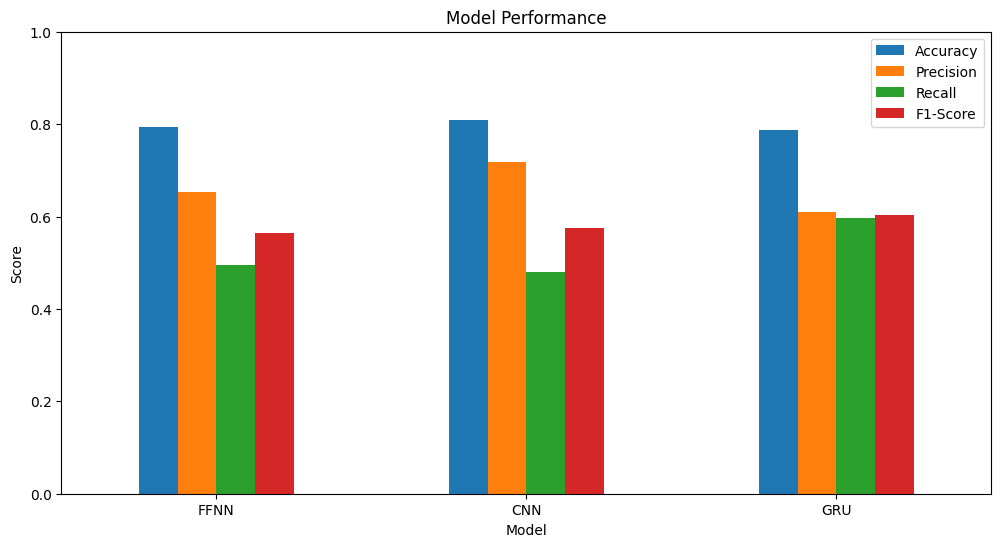

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('/content/ReadyToUseSD_Offensive.csv')
data['label'] = data['offensives'].map({'Offensive': 1, 'Non-Offensive': 0})

# Tokenization and padding
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(data['Tweet'])
sequences = tokenizer.texts_to_sequences(data['Tweet'])
X = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=128)
y = data['label'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# FFNN model
def create_ffnn():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(len(tokenizer.word_index) + 1, 100, input_length=128),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# CNN model
def create_cnn():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(len(tokenizer.word_index) + 1, 100, input_length=128),
        tf.keras.layers.Conv1D(128, 5, activation='relu'),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# GRU model
def create_gru():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(len(tokenizer.word_index) + 1, 100, input_length=128),
        tf.keras.layers.GRU(128),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train and evaluate each model
models = [('FFNN', create_ffnn), ('CNN', create_cnn), ('GRU', create_gru)]
results = []

for name, model_func in models:
    model = model_func()
    model.fit(X_train, y_train, epochs=3, batch_size=64, validation_split=0.2)
    _, acc = model.evaluate(X_test, y_test)
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_micro = f1_score(y_test, y_pred, average='micro')
    results.append((name, acc, precision, recall, f1, f1_macro, f1_micro))

# Print results in table format
df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'F1 Macro', 'F1 Micro'])
print(df)

# Plot results
df.set_index('Model').drop(columns=['F1 Macro', 'F1 Micro']).plot(kind='bar', figsize=(12, 6), ylim=(0,1), rot=0)
plt.ylabel('Score')
plt.title('Model Performance')
plt.show()
